<a href="https://colab.research.google.com/github/jeonggunlee/DeepLearningBasics/blob/master/Lab11_MEDICAL/medical_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

#pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mimg


import imgaug as aug
import imgaug.augmenters as iaa

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

#pip install pillow
from PIL import Image

from pathlib import Path

#pip install keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from skimage.io import imread
from skimage.transform import resize



#pip install opencv-python
import cv2

color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Any results you write to the current directory are saved as output.

In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'1.15.0'

In [0]:
!nvidia-smi

Wed Jan  8 16:41:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    35W / 250W |  15765MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls ./gdrive/My\ Drive/test

NORMAL	PNEUMONIA


In [0]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [0]:
# Define path to the data directory
data_dir = Path('./gdrive/My Drive/test')
print(data_dir)
test_dir = data_dir 

gdrive/My Drive/test


In [0]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
#print(os.listdir(normal_cases_dir))
# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    test_data.append((img,0))
# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,gdrive/My Drive/test/PNEUMONIA/person1662_viru...,1
1,gdrive/My Drive/test/PNEUMONIA/person21_virus_...,1
2,gdrive/My Drive/test/PNEUMONIA/person124_bacte...,1
3,gdrive/My Drive/test/PNEUMONIA/person136_bacte...,1
4,gdrive/My Drive/test/NORMAL/IM-0025-0001.jpeg,0


1    390
0    234
Name: label, dtype: int64


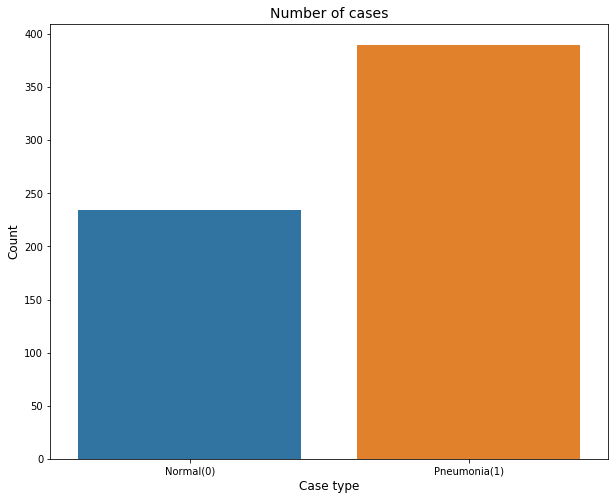

In [0]:

# Get the counts for each class
cases_count = test_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()


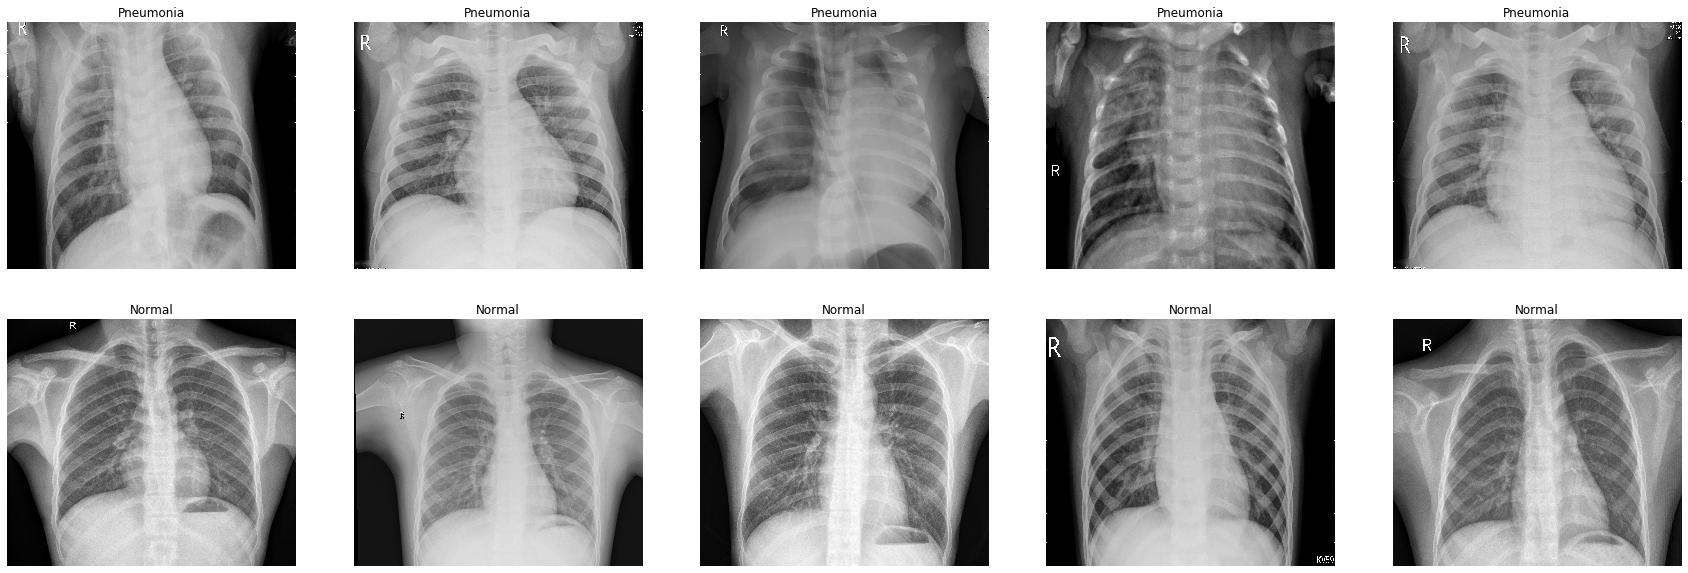

In [0]:

# Get few samples for both the classes
pneumonia_samples = (test_data[test_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (test_data[test_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()


In [0]:
# Augmentation sequence 
# iaa 라이브러리는 전처리 과정에 있어서 보다 쉽게 접근이 가능함
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
def build_model(): # VGG16 Model 구조
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model_VGG16 =  build_model() # VGG16
model_VGG16.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [0]:
from keras import applications
from keras.layers import Input
from keras.models import Model

def VGG_pretrain():
  input_tensor = Input(shape=(224, 224, 3)) 
  vgg_model = applications.VGG19(weights='imagenet', include_top=False,input_tensor=input_tensor)
  layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])
  Feature = layer_dict['block5_pool'].output
  x = Flatten(name='flatten')(Feature)
  x = Dense(1024, activation='relu', name='fc1')(x)
  x = Dropout(0.7, name='dropout1')(x)
  x = Dense(512, activation='relu', name='fc2')(x)
  x = Dropout(0.5, name='dropout2')(x)
  x = Dense(2, activation='softmax', name='fc3')(x)

  out = Model(inputs=input_tensor, outputs=x)

  return out

In [0]:
model_VGG19 = VGG_pretrain()
model_VGG19.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:

# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_VGG16', save_best_only=True, save_weights_only=True)
model_VGG16.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)
model_VGG19.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)


In [0]:
# Fit the model (실제 학습을 하기 위해서 train dataset을 google drive에 넣고 해야 하는데, 해당 데이터셋 파일의 용량이 1GB크기임으로 해당 실습 시간에는 직접 해보기에는 불가능할 것 같아 결과확인을 위해 소스만 표기)
'''
history = model_VGG16.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                               class_weight={0:1.0, 1:0.4})
'''



Epoch 1/10
81/81 [==============================] - 1468s 18s/step - loss: 0.3777 - acc: 0.5107 - val_loss: 0.5992 - val_acc: 0.6875
Epoch 2/10
81/81 [==============================] - 708s 9s/step - loss: 0.1285 - acc: 0.9061 - val_loss: 1.0798 - val_acc: 0.5000
Epoch 3/10
81/81 [==============================] - 350s 4s/step - loss: 0.0864 - acc: 0.9479 - val_loss: 0.5998 - val_acc: 0.7500
Epoch 4/10
81/81 [==============================] - 234s 3s/step - loss: 0.0634 - acc: 0.9589 - val_loss: 0.9682 - val_acc: 0.5625
Epoch 5/10
81/81 [==============================] - 147s 2s/step - loss: 0.0504 - acc: 0.9678 - val_loss: 0.8414 - val_acc: 0.5000
Epoch 6/10
81/81 [==============================] - 118s 1s/step - loss: 0.0408 - acc: 0.9757 - val_loss: 0.1863 - val_acc: 0.8750
Epoch 7/10
81/81 [==============================] - 100s 1s/step - loss: 0.0427 - acc: 0.9711 - val_loss: 0.4134 - val_acc: 0.8750
Epoch 8/10
81/81 [==============================] - 93s 1s/step - loss: 0.0408 

In [0]:
!ls
!cp best_model_VGG16 ./gdrive/My\ Drive/best_model_VGG16.h5

best_model_VGG16  gdrive  sample_data


In [0]:
data_dir = Path('./gdrive/My Drive')
print(os.listdir(data_dir))

['ubuntu-16.04.6-desktop-amd64.iso', '학습30000번weight사용.mp4', 'darknet설치및실행방법.mp4', 'Colab Notebooks', '배치학습과온라인학습_2주차.pptx', 'DeepLearning', 'chest_xray', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'chest_model.h5', '72_model.h54', '72_model.h5', 'best_model_todate', 'best_model_VGG19', 'best_model_VGG19.h5', 'Dataset', '이산구조 채점표.xlsx', '이산구조 채점표.gsheet', 'test', 'medical_exam_1.ipynb', 'best_model_VGG16.h5']


In [0]:
model_VGG19.load_weights('./gdrive/My Drive/best_model_VGG19.h5')

In [0]:
test_dir = Path('./gdrive/My Drive/chest_xray/chest_xray/test')

# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

#.jpeg 확장명을 가진 파일만 추출
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1: #gray_scale
        img = np.dstack([img, img, img])
    else: # RGB ( channel = 3 )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2) # one-hot encoding [ 1 , 0 ]
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1: #gray_scale
        img = np.dstack([img, img, img])
    else: # RGB ( channel = 3 )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB ( opencv로 읽은 경우 data의 형태는 BGR이기 때문에 )
    img = img.astype(np.float32)/255. # Normalize
    label = to_categorical(1, num_classes=2)  # one-hot encoding [ 0 , 1 ]
    test_data.append(img)
    test_labels.append(label)
    
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [0]:
# Evaluation on test dataset
test_loss, test_score = model_VGG19.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 3s 4ms/step
Loss on test set:  1.5534398926023034
Accuracy on test set:  0.7628205128205128


In [0]:
# Get predictions
preds = model_VGG19.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


## VGG19 모델을 사용하여 학습한 결과

<Figure size 432x288 with 0 Axes>

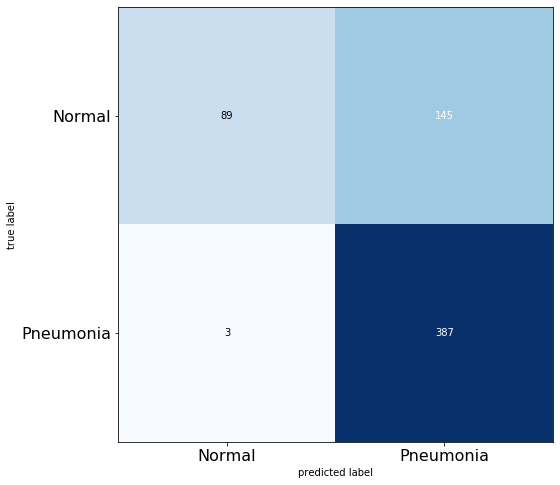

In [0]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.73


In [0]:
model_VGG16.load_weights('./gdrive/My Drive/best_model_VGG16.h5')

In [0]:
# Evaluation on test dataset
test_loss, test_score = model_VGG16.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 2s 3ms/step
Loss on test set:  0.6092029218860449
Accuracy on test set:  0.8253205128205128


In [0]:
# Get predictions
preds = model_VGG16.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


## VGG16 모델을 사용하여 학습한 결과

<Figure size 432x288 with 0 Axes>

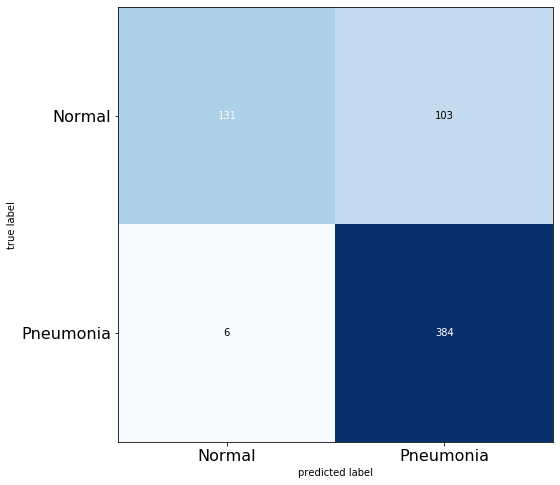

In [0]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.79
